# OCR Agent from scratch:

* [Data](Data-Sources.ipynb)
* [Utilities](Data-Processing.ipynb)
* Extract layout features and visual tokens
    * Cells and grid-lines (tables)
    * [Text-lines, word-level objects, char-level tokens](Data-Extraction-2.ipynb)
* [Generate training data](Data-Extraction-3.ipynb)
* [Model architecture](Model-Backbone.ipynb)
* [Traversal strategies](Traversal-Layout.ipynb)
* [Reader Agent](Agent-LM.ipynb)
* [Leverage synthetic training data](Data-Gen.ipynb)
* [Optimization for production](Optimization.ipynb)


### Detect and extract long lines
( Default parameters set for the resolution of `250-350 dpi`:
for lower / higher resolutions parameters should be readjusted. )

In [1]:
import cv2
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from PIL import Image
from matplotlib import pyplot as plt
from matplotlib import patches
from pathlib import Path

In [2]:
from scripts.extract import *

In [3]:
samples = [str(x)[12:-4] for x in Path('./data/images').glob('*.png')]
len(samples)

8633

In [4]:
source = np.random.choice(samples)

In [5]:
print(source)
image = load_image(source)
print(np.min(image), np.max(image))
#Image.fromarray(image)

irs-f8936-1
0 255


### Extract grid-lines first if present
To ensure we identify and aggregate continuous text-blocks correctly we have to pay attention to the lines.

In [6]:
def extract_lines(image, scale=(20, 10)):
    dv, dh = image.shape[0]//scale[0], image.shape[1]//scale[1]
    output = cv2.erode(image, np.ones((5, 5), np.uint8), iterations=1)
    output = cv2.bitwise_not(sharpen(output))
    output = cv2.adaptiveThreshold(output, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 15, -1)
    # create images to hold extracted lines
    v, h = np.copy(output), np.copy(output)
    vs = cv2.getStructuringElement(cv2.MORPH_RECT, (1, dv//2))
    hs = cv2.getStructuringElement(cv2.MORPH_RECT, (dh, 1))
    v, h = cv2.erode(v, vs), cv2.erode(h, hs)
    v, h = cv2.dilate(v, vs), cv2.dilate(h, hs)
    return v, h


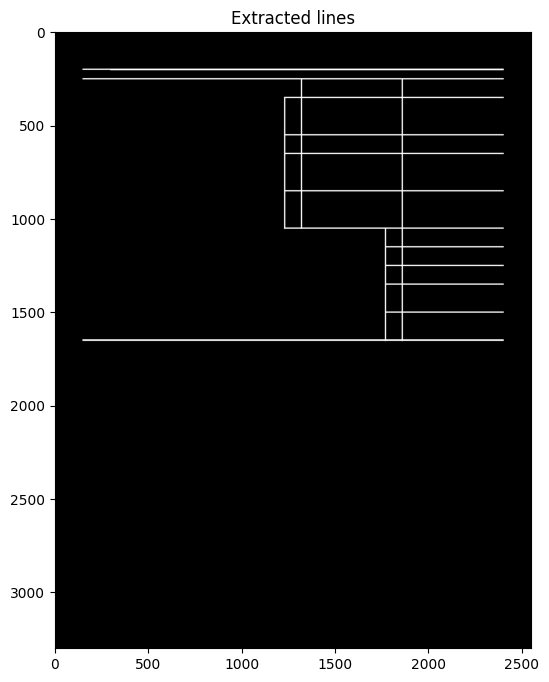

In [7]:
# to catch checkboxes or vertical ticks the scale should be more detailed
#vertical, horizontal = extract_lines(image, scale=(30, 50))
vertical, horizontal = extract_lines(image)
grid = vertical + horizontal

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(grid, 'gray')
plt.title('Extracted lines')
plt.show()

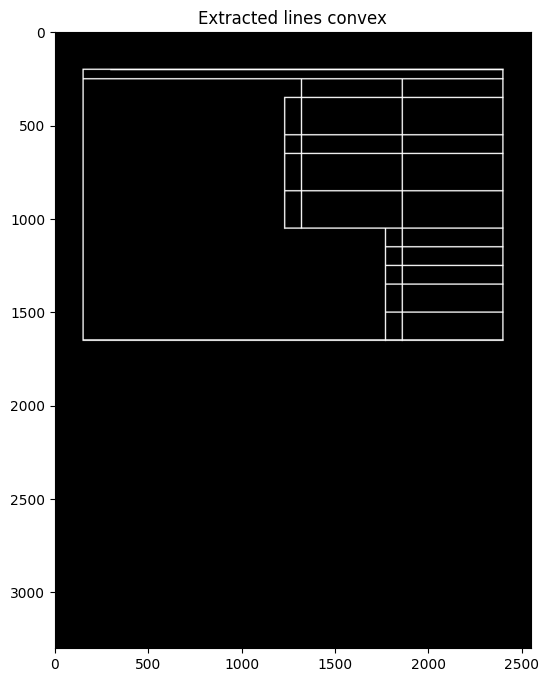

In [8]:
def make_convex(grid, kernel=(7, 7)):
    convex = grid.copy()
    indices = np.array(grid.nonzero())
    if len(indices[1]) == 0:
        return convex
    x0, y0 = np.min(indices, axis=1)
    x1, y1 = np.max(indices, axis=1)
    convex[x0:x0 + kernel[0], y0:y1] = 255
    convex[x1 - kernel[0]:x1, y0:y1] = 255
    convex[x0:x1, y0:y0 + kernel[1]] = 255
    convex[x0:x1, y1 - kernel[1]:y1] = 255
    return convex

convex = make_convex(grid)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(convex, 'gray')
plt.title('Extracted lines convex')
plt.show()

In [9]:
def extract_cells(grid, f=2, kernel=(5, 5), convex=False, visual=False):
    output = 255 - (make_convex(grid, kernel=kernel) if convex else grid)
    output = resample(output, f)
    output = cv2.erode(output, np.ones(kernel, np.uint8), iterations=1)
    output = cv2.threshold(output, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    visual_check(output, visual)
    c, h = cv2.findContours(output, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # return bounding-box and parent-ref
    #return [np.append((np.array(cv2.boundingRect(c[i])) * f), h[0][i][-2:]) for i in range(len(c))]
    return [np.array(cv2.boundingRect(c)) * f for c in c]


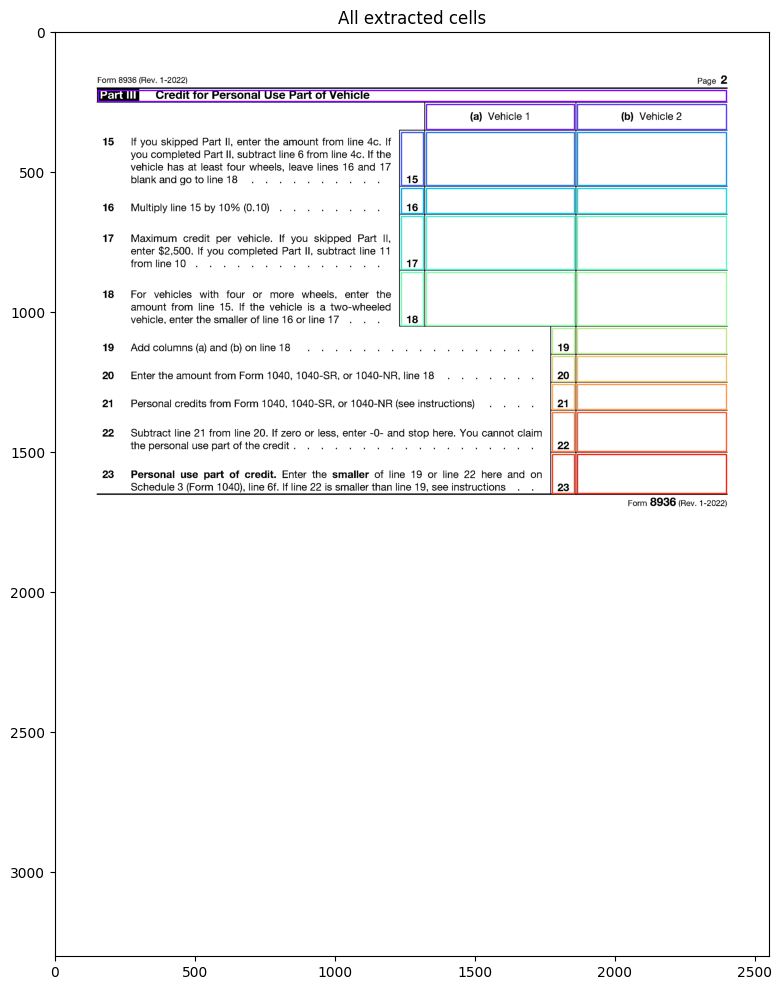

In [10]:
cells = extract_cells(grid, convex=True)
cells = [(x, y, w, h) for x, y, w, h in cells if w >= 20 and h >= 20] # exclude lines
cells = filter_boxes(cells, image.shape, reverse=False) # remove parents
if len(cells) > 2:
    cells = pd.DataFrame(cells, columns=BOX).sort_values(['top','left'])
    cells['type'] = CELL
    
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(image, 'gray')
    for c, (x, y, w, h, t) in enumerate(cells.values):
        color = plt.cm.rainbow(c/len(cells))
        ax.add_patch(patches.Rectangle((x, y), w, h, linewidth=1, facecolor='none', edgecolor=color))
    plt.title('All extracted cells')
    plt.show()


### Lines as tokens

Inputs often presented by *underlines* and *underlines with ticks*.

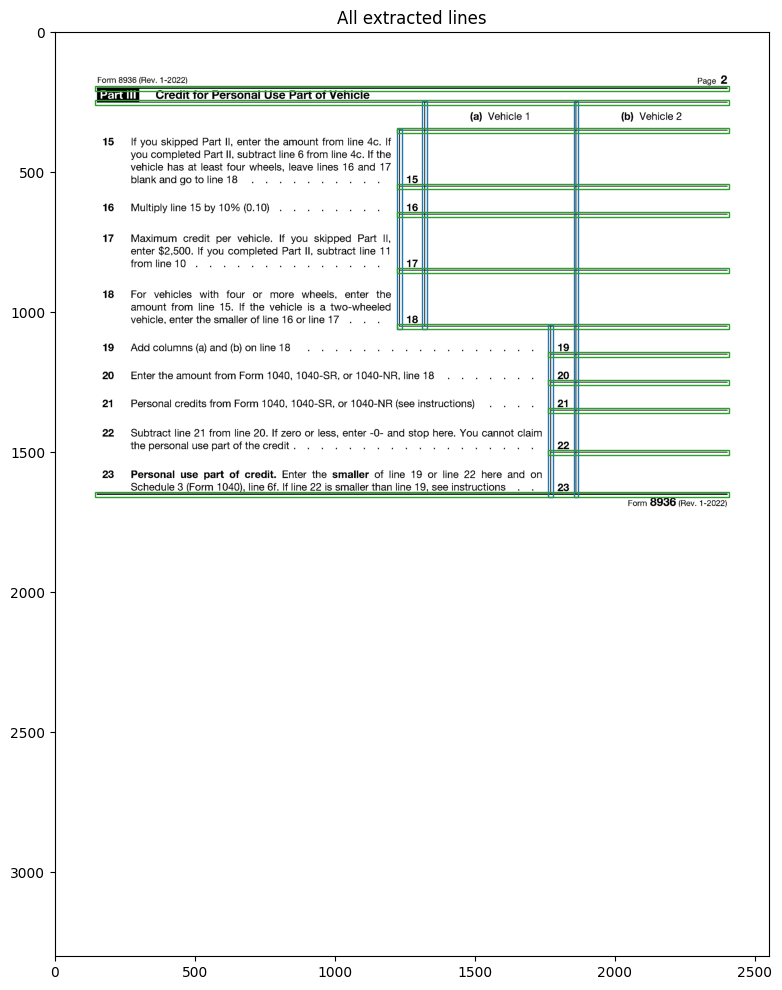

In [11]:
V, H = extract_lines(image, scale=(20, 10))
vlines = extract_cells(V, convex=False)
vlines = pd.DataFrame(vlines, columns=BOX)
vlines['type'] = VLINE

hlines = extract_cells(H, convex=False)
hlines = pd.DataFrame(hlines, columns=BOX)
hlines['type'] = HLINE

fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(image, 'gray')
for x, y, w, h, t in vlines.values:
    ax.add_patch(patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='C0', facecolor='none'))
for x, y, w, h, t in hlines.values:
    ax.add_patch(patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='C2', facecolor='none'))
plt.title('All extracted lines')
plt.show()

In [12]:
# vertical lines relative position and size stats
(vlines[['left','top','height']]/image.shape[0]).describe().iloc[1:,:].style.background_gradient()

,left,top,height
mean,0.465758,0.142121,0.270000
std,0.095779,0.117037,0.108908
min,0.370303,0.073939,0.186667
25%,0.390758,0.073939,0.209394
50%,0.465758,0.089091,0.232121
75%,0.540758,0.157273,0.292727
max,0.561212,0.316364,0.429091


In [13]:
# horizontal lines relative position and size stats
(hlines[['left','top','width']]/image.shape[1]).describe().iloc[1:,:].style.background_gradient('Greens')

,left,top,width
mean,0.443922,0.349804,0.500392
std,0.252723,0.195543,0.252723
min,0.055686,0.075294,0.253333
25%,0.373333,0.192941,0.253333
50%,0.479216,0.369412,0.465098
75%,0.690980,0.496863,0.570980
max,0.690980,0.643922,0.888627


In [14]:
# used for threshold as minimal heights for a token
LT = hlines['height'].mean() if len(hlines) > 0 else 20

In [15]:
def get_grid(image, lt=20, m=4):
    # to catch vertical ticks the scale should be more detailed (30, 50)
    V, H = extract_lines(image)
    grid = V + H
    cells = extract_cells(grid, f=2, kernel=(5, 5), convex=True)
    # exclude lines add margin
    cells = [(x - m, y - m, w + m * 2, h + m * 2) for x, y, w, h in cells if w >= 20 and h >= lt]
    # remove parents
    cells = filter_boxes(cells, image.shape, reverse=False)
    if len(cells) > 0:
        cells = pd.DataFrame(cells, columns=BOX).sort_values(['top','left']).reset_index(drop=True)
        cells['type'] = CELL

    V, H = extract_lines(image, scale=(20, 10))
    vlines = pd.DataFrame(extract_cells(V, convex=False), columns=BOX)
    if len(vlines) > 0:
        vlines['type'] = VLINE

    hlines = pd.DataFrame(extract_cells(H, convex=False), columns=BOX)
    if len(hlines) > 0:
        hlines['type'] = HLINE
        
    # remove all line from the image for the further text extraction
    # mask will also serve as a reading map
    mask = image.copy()
    mask[V.nonzero()] = 255
    mask[H.nonzero()] = 255
        
    return mask, vlines, hlines, cells


In [16]:
mask, vlines, hlines, cells = get_grid(image, LT)
# check mask
#Image.fromarray(mask)

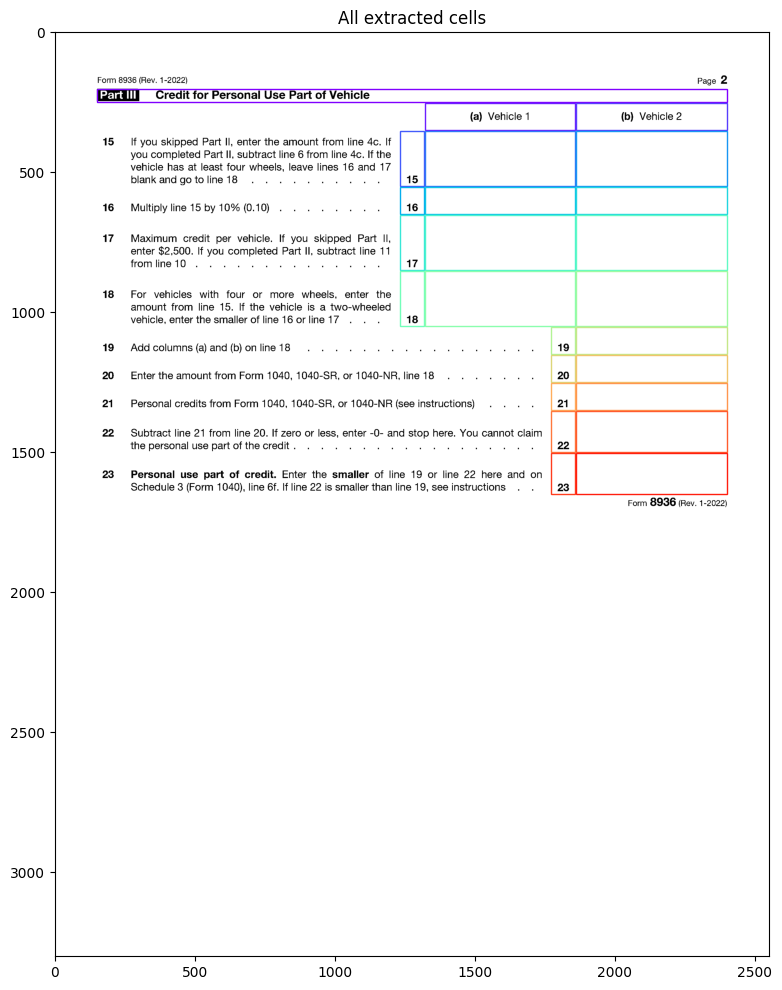

In [17]:
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(mask, 'gray')
    for c, (x, y, w, h, t) in enumerate(cells.values):
        color = plt.cm.rainbow(c/len(cells))
        ax.add_patch(patches.Rectangle((x, y), w, h, linewidth=1, facecolor='none', edgecolor=color))
    plt.title('All extracted cells')
    plt.show()

Takeaway: rule-based extraction might be fragile as parameters are extremely sensitive for data drift -- the main reason we want to go agentic here.